In [41]:
import sys
import logging
import matplotlib.pyplot as plt
import random
from rdkit import Chem, SimDivFilters, DataStructs
from rdkit.Chem import Draw, rdMolDescriptors
from rdkit.SimDivFilters import rdSimDivPickers

logging.basicConfig(format = '%(levelname)s - %(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level = logging.ERROR)
sys.path.append('/hpc/mydata/stv/fr645797/mGAP/')
from mGap_rebase_DBprocess_v2 import get_bbgap_configuration, process_db, SelectCompounds, Timer, Picker, visualise_properties
from mGAP_rebase_densityclustering_v3 import selection_maps

plt.rcParams['figure.figsize'] = [15,10]

In [2]:
# To simplify the environments:
# Ensure that
# conda env create --name myenv -f environment.yml
# https://github.com/gsk-tech/olivecrona-RNN/blob/master/packages.yml
# mamba vs conda.

# Comparison of Selection algorithms

The purpose of this notebook is to show a comparison of the different methods of a selection of n compounds from N compounds where n << N.<br>
The methods that will be compared are:
 - The monomer gap selection method
 - k-means clustering method (selecting centroids)
 - The Sphere exclusion method (selecting centroids)
 - The MaxMin selection method (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598)
 - Random selection
 
Analyses will be performed for each selection method
- For each method, the selection will be shown, followed by the coverage according to mGAP
- This is followed by a comparison of the Tanimoto similarities of each of the selection methods
- This is followed by a comparison of the physicochemical property distribution of the set


In [3]:
input_ref = './data/enamine_acids/enamine_acids/enamine_acids_filtered_omega.ref'
input_bin = './data/enamine_acids/enamine_acids/enamine_acids_filtered_omega.bin'
n_select = 96

## bbGAP self-organising map partitioning method
This is a selection method based on pharmacophore placement
- mGAP code located in mGapDBprocess.py, with a picker object similar to those used in RDKit
- Because some compounds fail conformer generation (due to bad smiles / stereochemistry which is not allowed), the compounds that pass will be used as the basis for the other selection methods

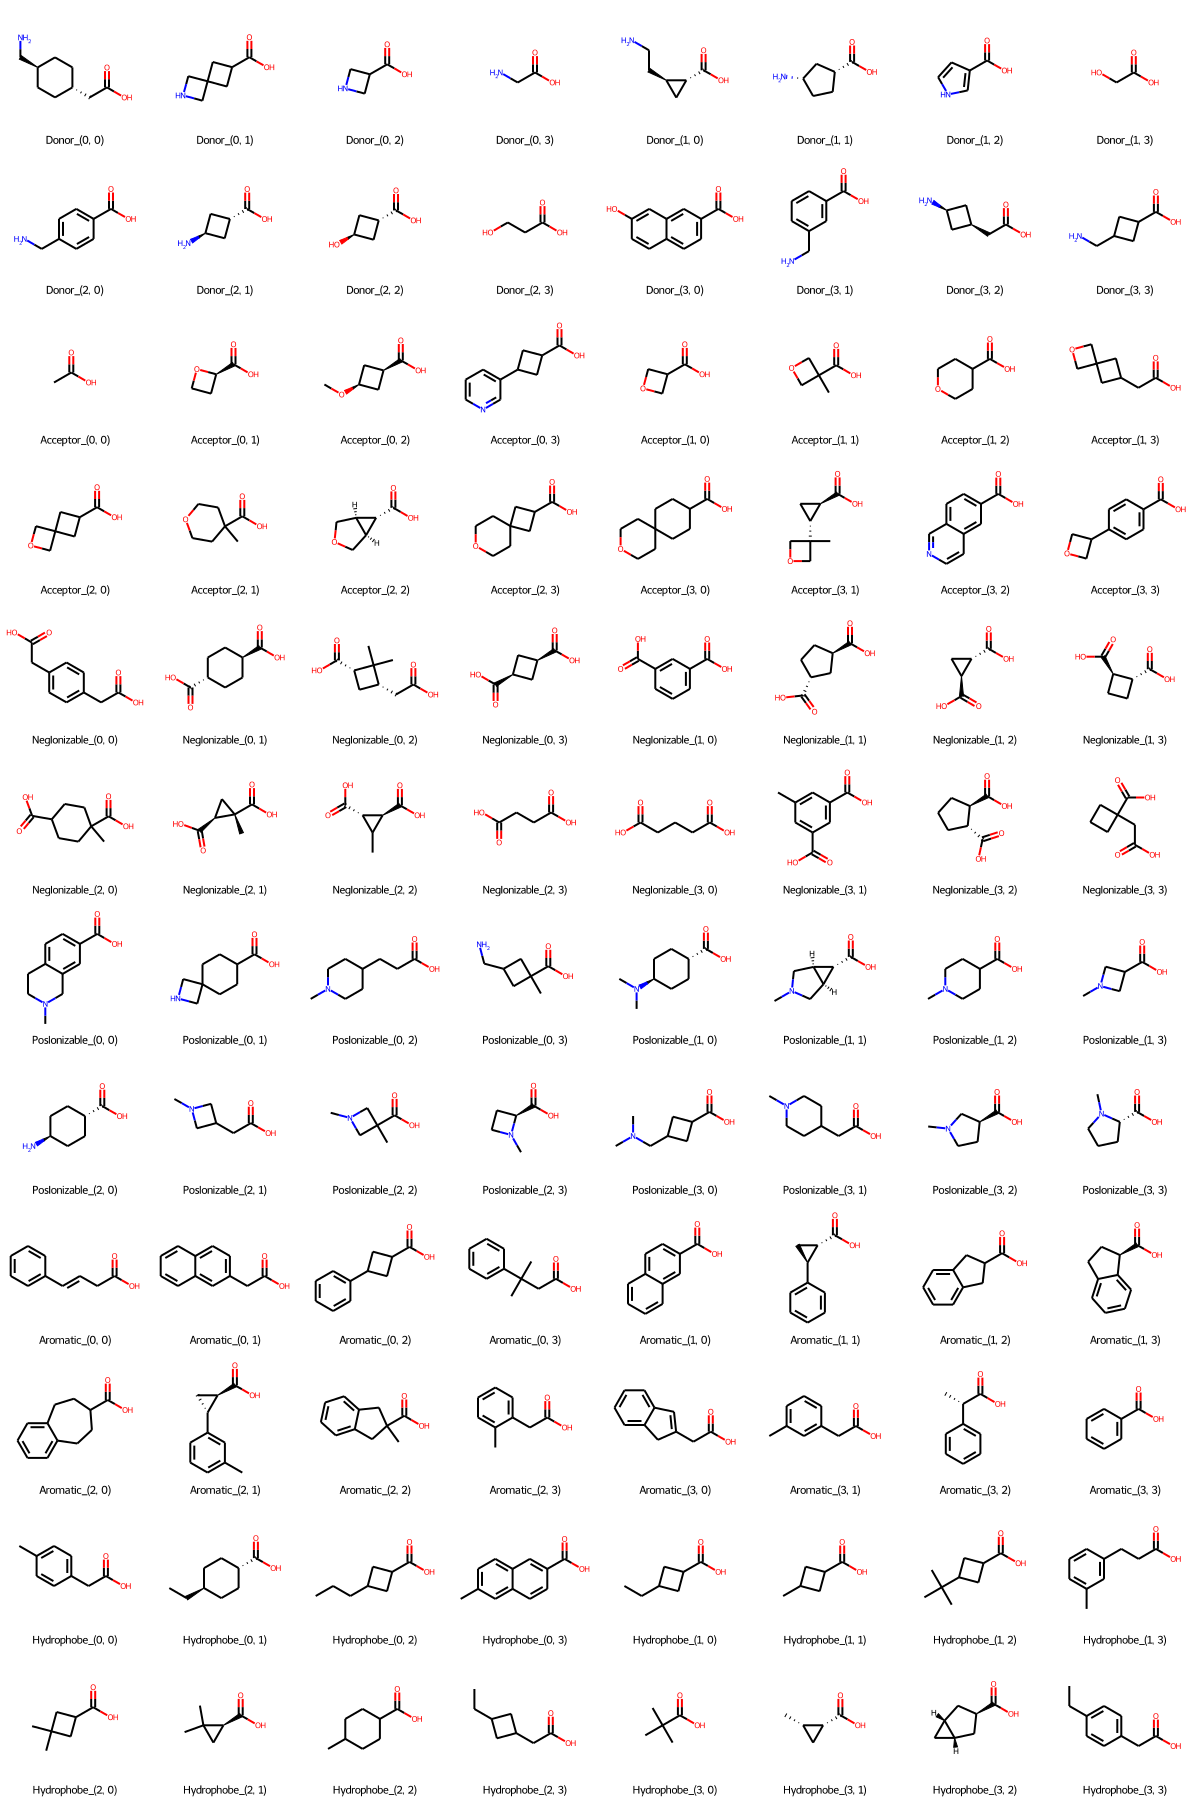

In [4]:
# run the bbGAP selection, using the SOM method
som_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = n_select,  # How many compounds to select
                          method = 'som', # Which clustering method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0.9,
                            use_coverage = False,)

#mGAPclustering = mGAP_selection._mGAPclustering 
som_selected_smiles_dict = som_selection.GetSelectionDict()
som_selected_molnames = som_selection.GetSelectionIDs()
## Get all smiles and molnames from the set
smiles = som_selection.GetAllSmiles()
molnames = som_selection.GetAllIds()
#list(mGAP_selection._selection_table.index
som_selection.DrawSelectedMols(align_smiles = 'CC(=O)O')

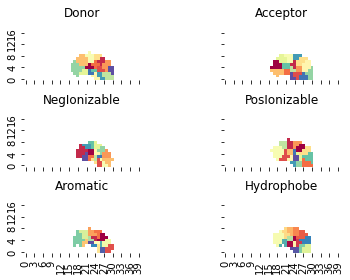

In [5]:
## View the clustering performed by mGAP
fig = som_selection.VisualisePartitioning()

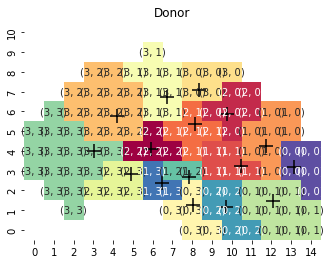

In [6]:
som_selection.VisualisePartitioningDetail(pharmacophore = 'Donor')

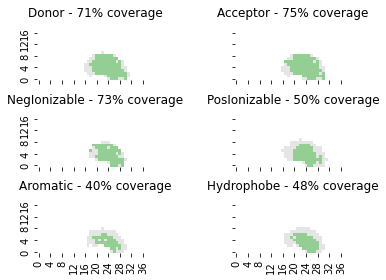

In [7]:
## mGAP coverage
fig = som_selection.VisualiseCoverage()

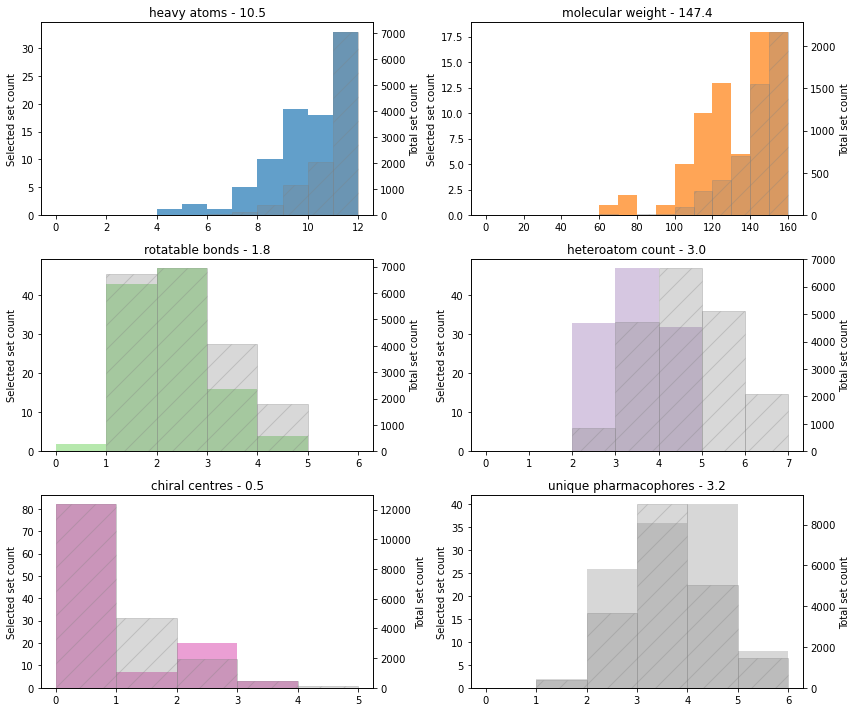

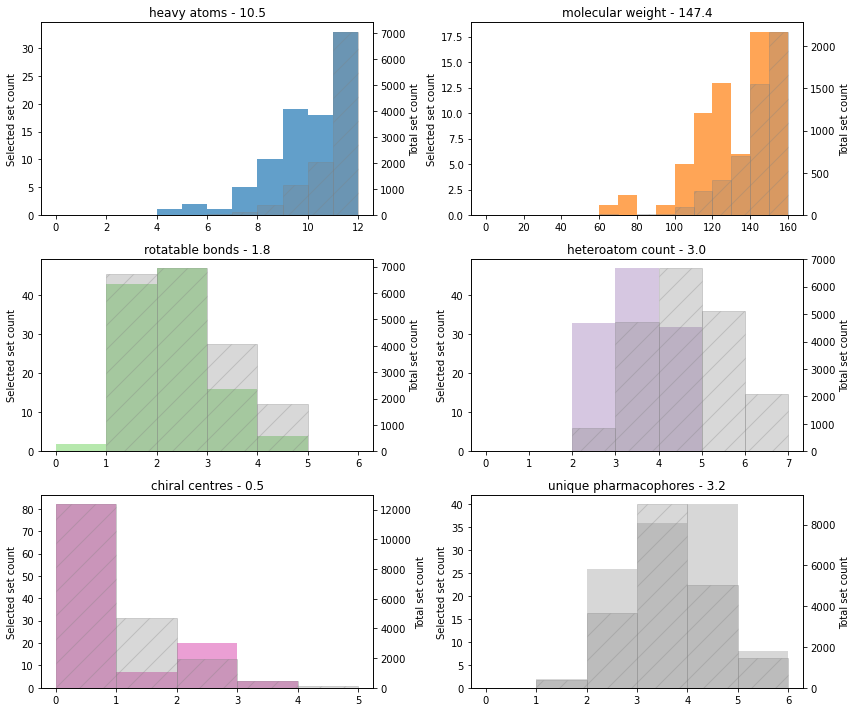

In [8]:
visualise_properties(som_selection.GetDataTable(), som_selected_molnames, molnames, twinx = True)

## bbGAP classic partitioning method

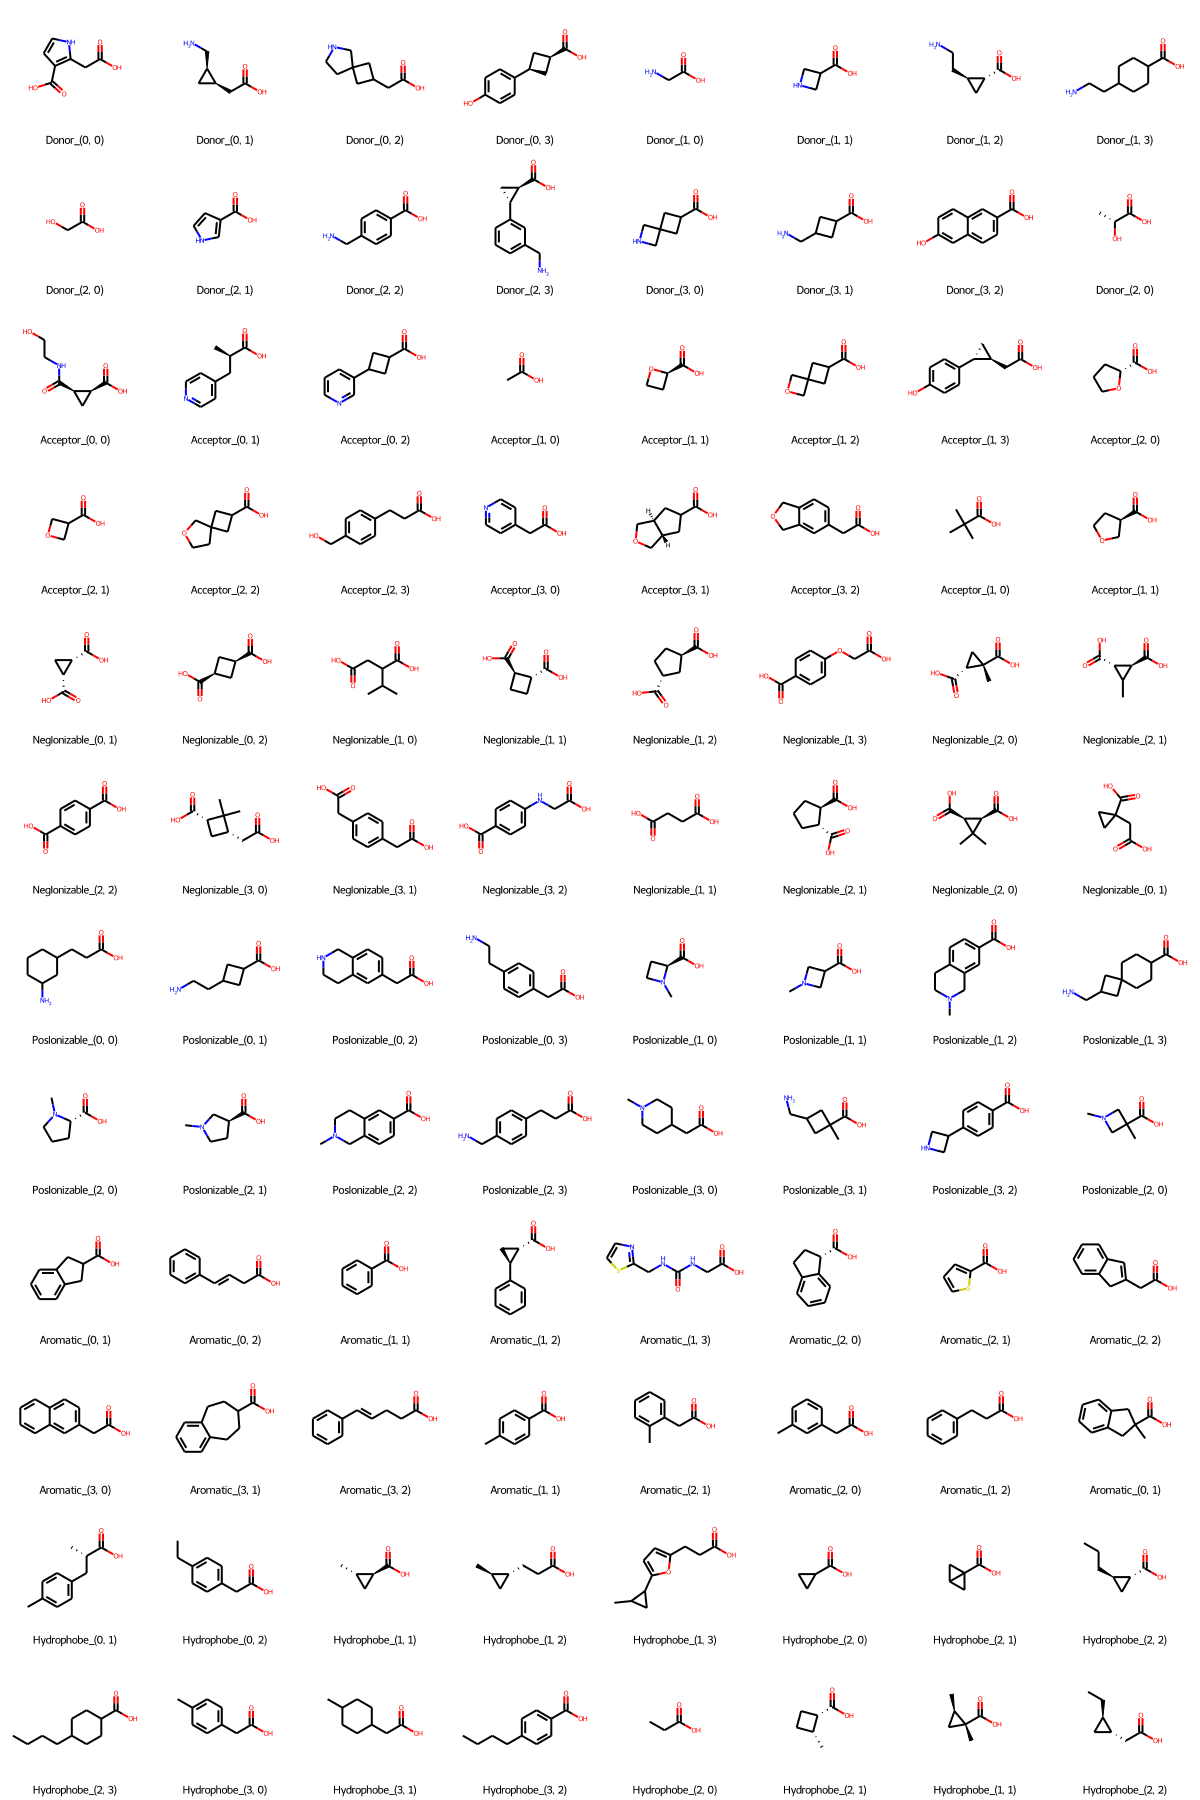

In [9]:
classic_selection = Picker(ref_file = input_ref, 
                            bin_file = input_bin, 
                            n = n_select,  # How many compounds to select
                            method = 'classic', # Which clustering method to use
                            pharmacophores = '*', # Which pharmacophore to select from,
                            select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            sort = 'MPO',
                            ncpu = 15,)  # Number of cpus to use)

## Get smiles as a list
#smiles = list(classic_selection._selection_table['smiles'])
#molnames = list(classic_selection._selection_table.index)

classic_selected_smiles_dict = classic_selection.GetSelectionDict()
classic_selected_molnames = classic_selection.GetSelectionIDs()
classic_selection.DrawSelectedMols(align_smiles = 'CC(=O)O')

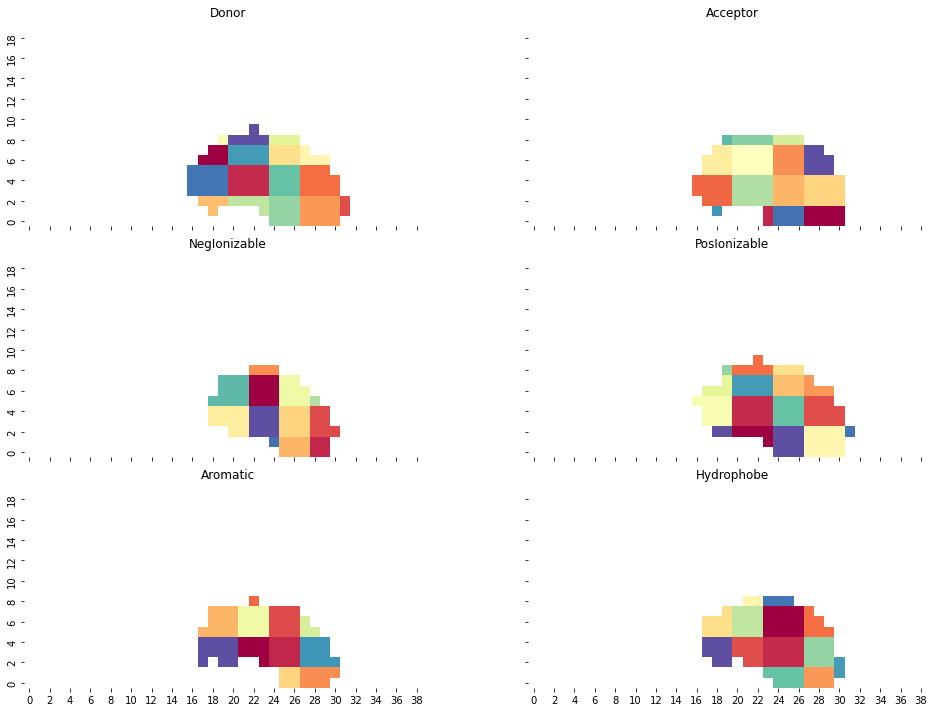

In [10]:
## View the clustering performed by mGAP
fig = classic_selection.VisualisePartitioning()

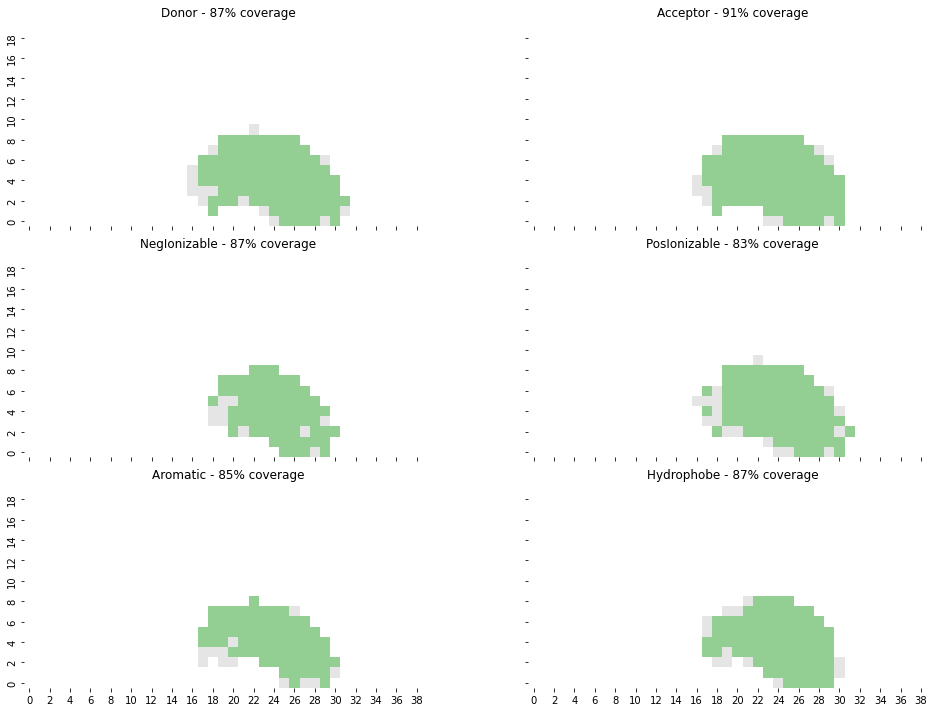

In [11]:
fig = classic_selection.VisualiseCoverage()

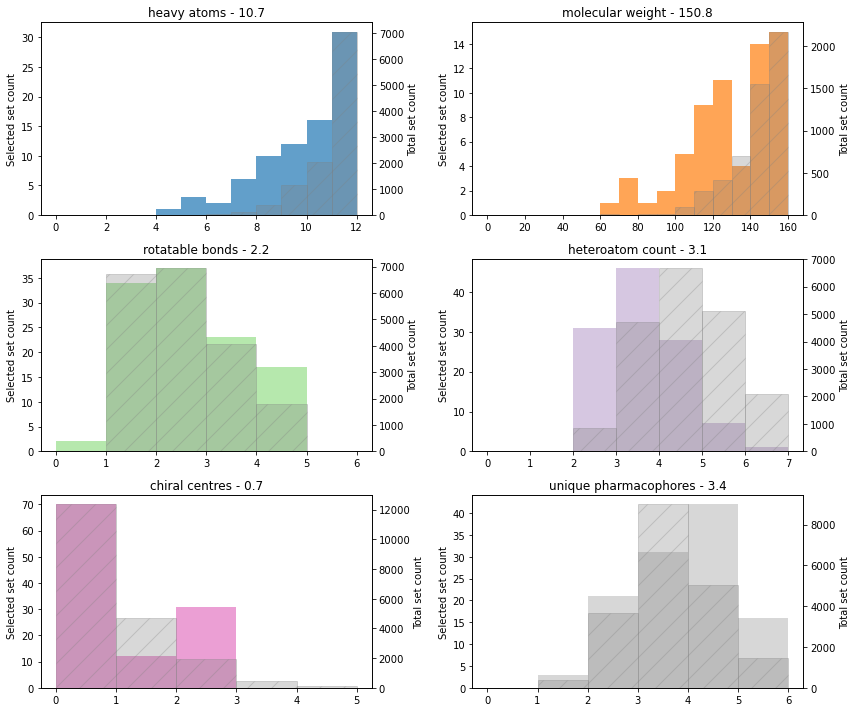

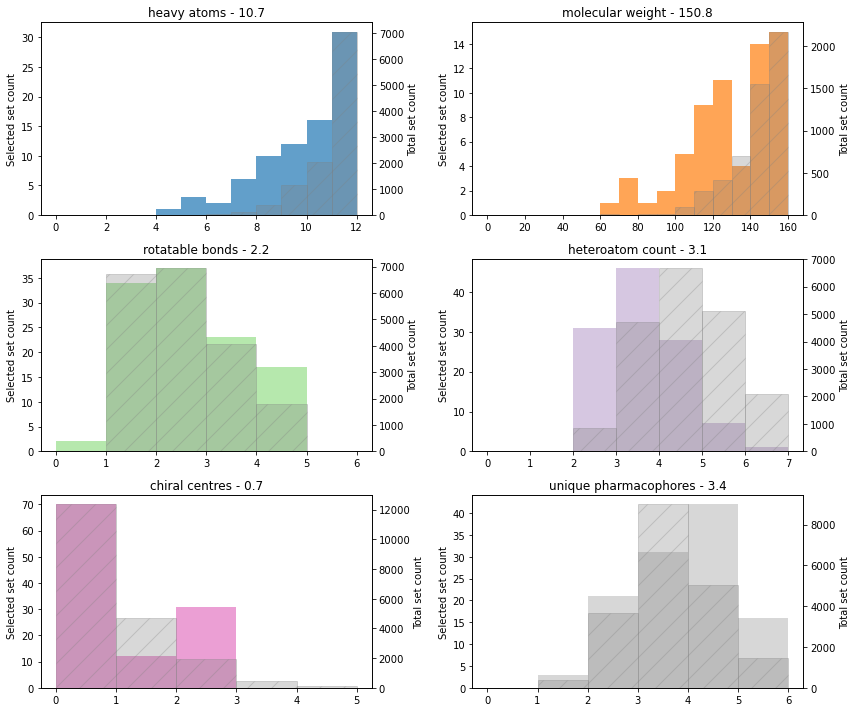

In [12]:
visualise_properties(classic_selection.GetDataTable(), classic_selected_molnames, molnames, twinx = True)

## Full coverage

In [13]:
full_selection = Picker(ref_file = input_ref, 
                        bin_file = input_bin, 
                               n = 48,  # How many compounds to select
                          method = 'full_coverage', # Which partitioning method to use
                  pharmacophores = '*', # Which pharmacophore to select from,
                        select_mode = 1, # How to distribute selection amongst pharmacophore:0- by area covered by pharmacophore, 1 - evenly, 2 - proportionally on a log scale, 3 - proportionally
                            ncpu = 10,  # Number of cpus to use,
                            sort = 'MPO',
                            tanimoto = 0)

full_selected_smiles_dict = full_selection.GetSelectionDict()
full_selected_molnames = full_selection.GetSelectionIDs()

print(f'full coverage achieved with {len(full_selected_molnames)} picks')
full_selection.DrawSelectedMols(align_smiles = 'CC(=O)O')

full coverage achieved with 245 picks


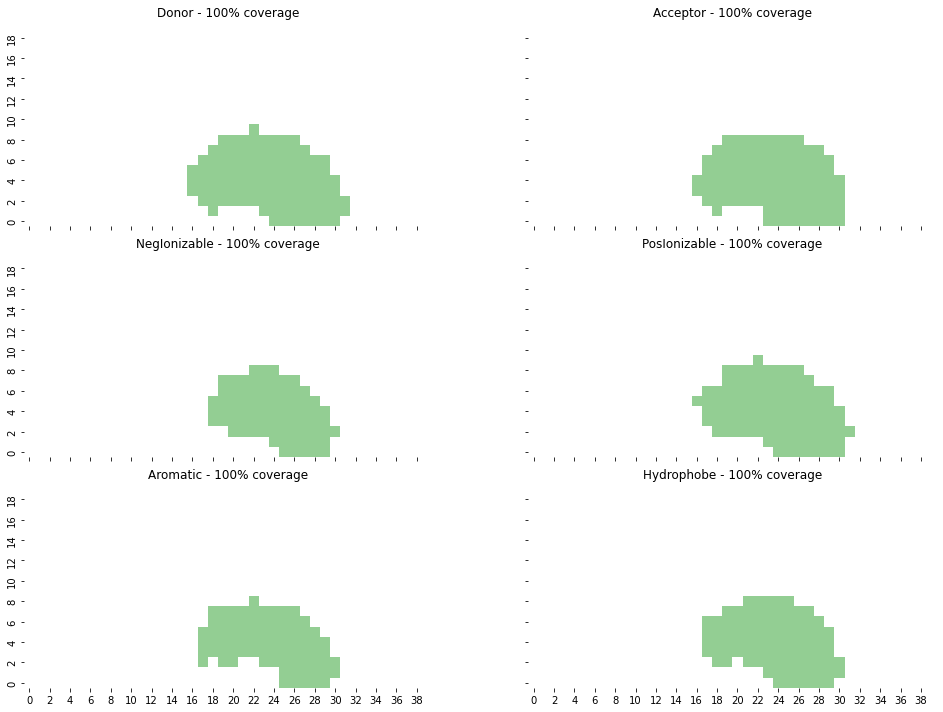

In [14]:
fig = full_selection.VisualiseCoverage()

## Random selection
> - Just taking a random sample of compounds from the set

In [15]:
## Get the molecule objects as a list
mols = []
for sm, ID in zip(smiles, molnames):
    #try:
    mol = Chem.MolFromSmiles(sm)
    #except:
        #print(f'could not convert {sm};{ID}')
        
        #continue
    mols.append(mol)

In [16]:
## Get random selection
molnames = list(som_selection._selection_table.index)
random.seed(3)
random_picks = random.sample([i for i,j in enumerate(mols)], n_select)
random_molnames = [molnames[x] for x in random_picks]

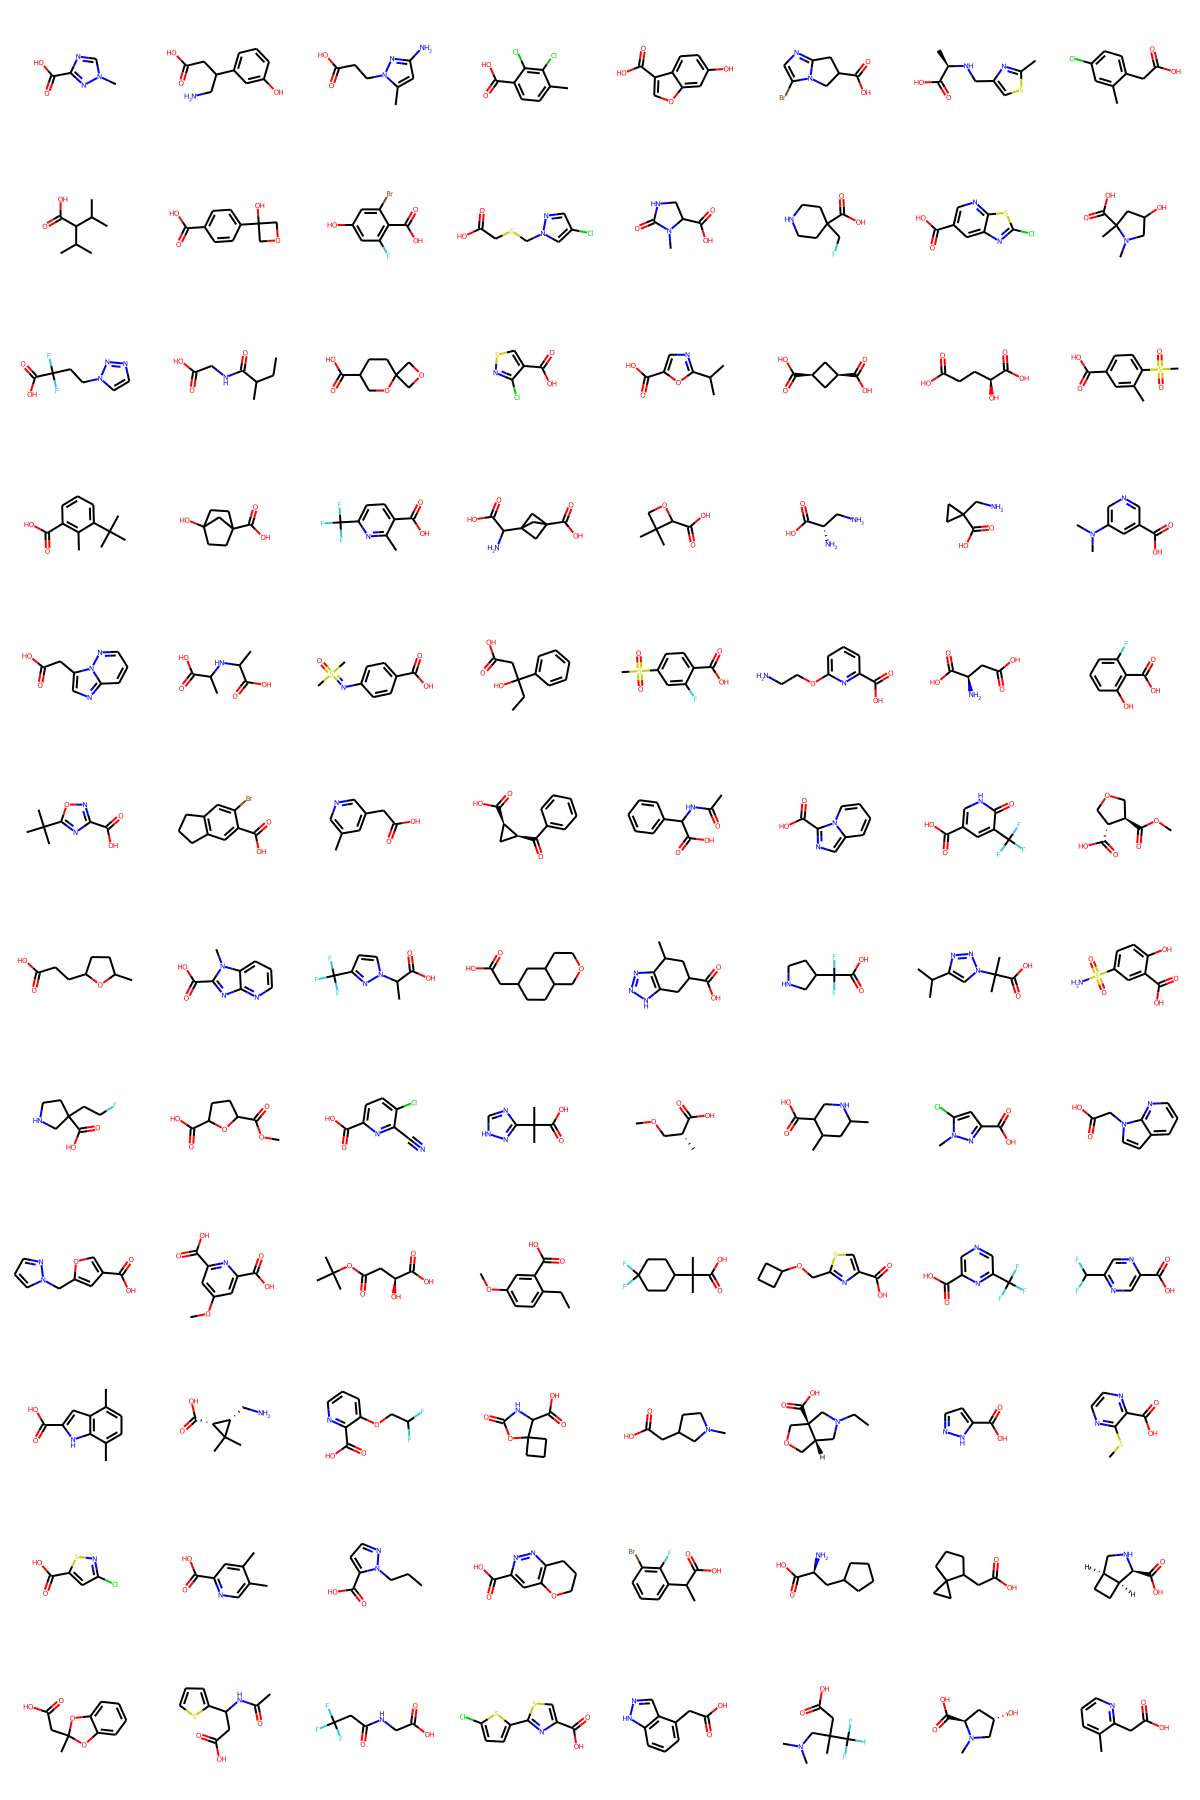

In [17]:
Draw.MolsToGridImage([mols[x] for x in random_picks], molsPerRow=8, maxMols=100, subImgSize=(150,150))

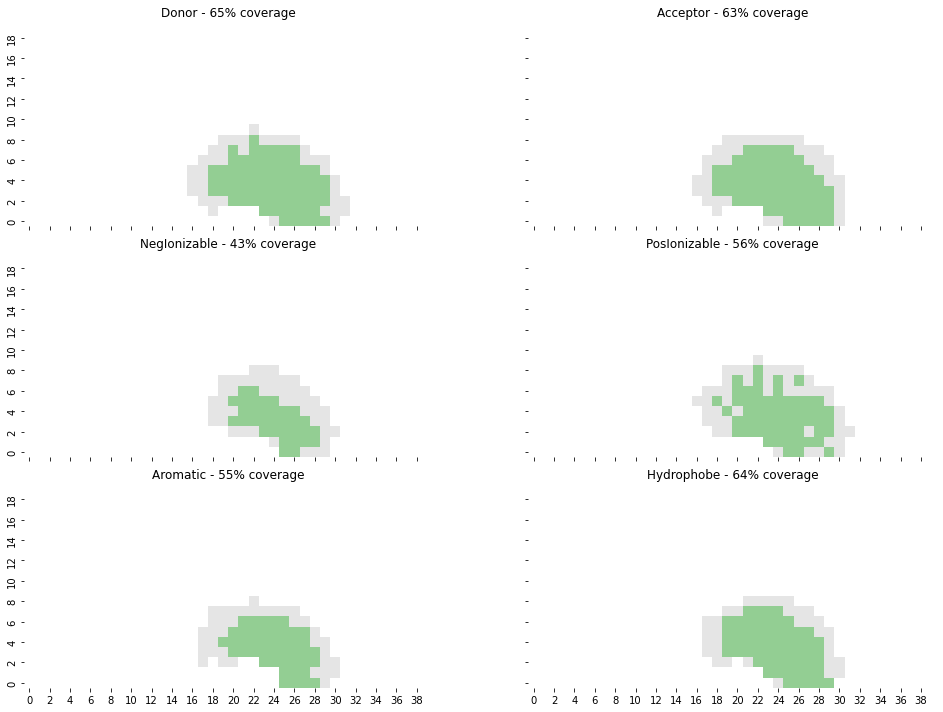

In [18]:
## Random coverage
classic_selection.SimulateCoverage(molnames = random_molnames)

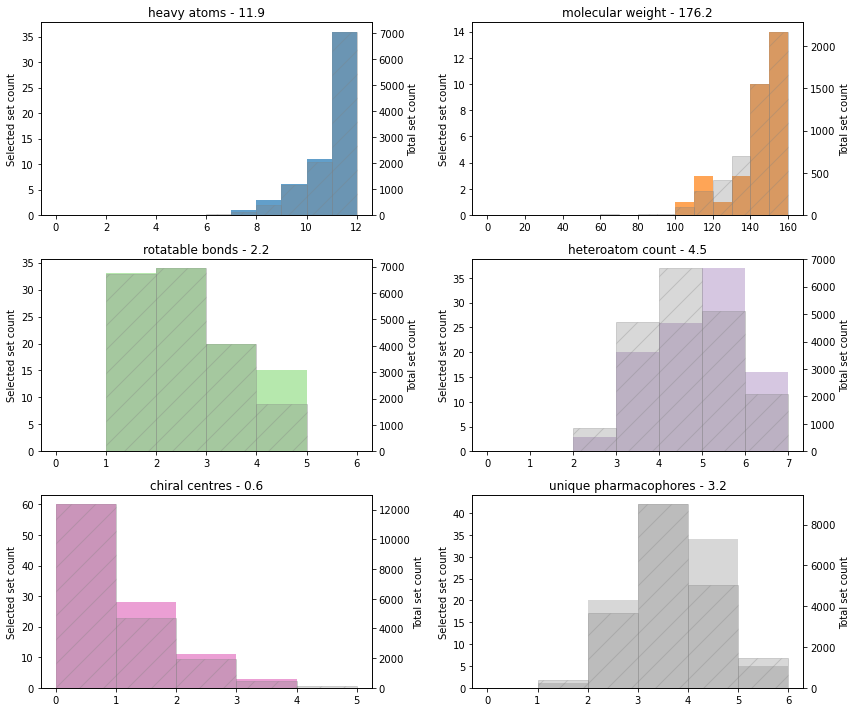

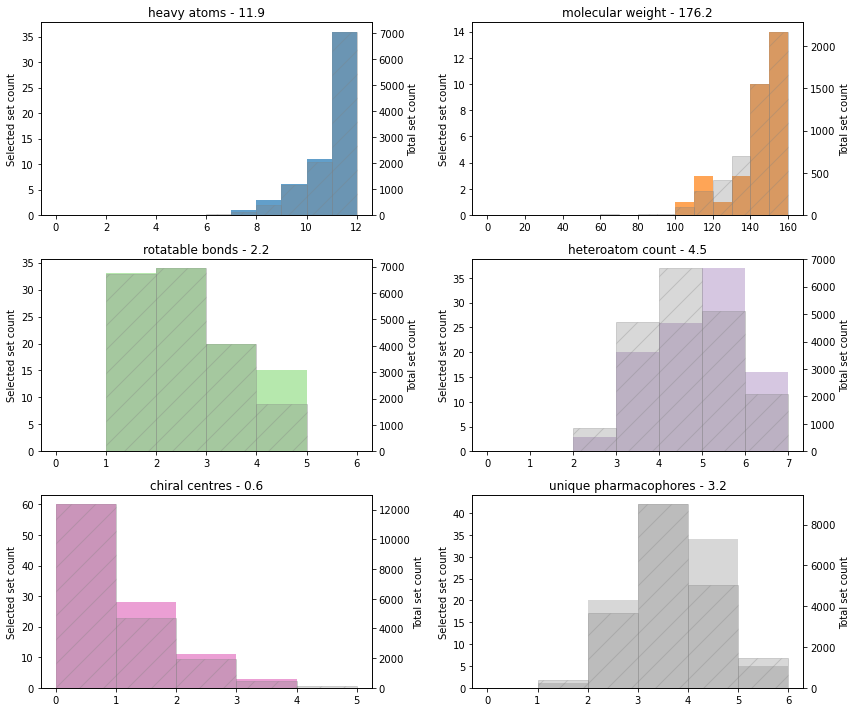

In [19]:
visualise_properties(classic_selection.GetDataTable(), random_molnames, molnames, twinx = True)

## Sphere-exclusion clustering

> - Butina method from rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html
> - Refs:
>> - D. Butina,          J. Chem. Inf. Comput. Sci. 1999, 39, 747
>> - A. Gobbi, M. Lee,   J. Chem. Inf. Comput. Sci. 2003, 43, 1, 317
>> - R. Sayle            https://raw.githubusercontent.com/rdkit/UGM_2019/master/Presentations/Sayle_Clustering.pdf


96


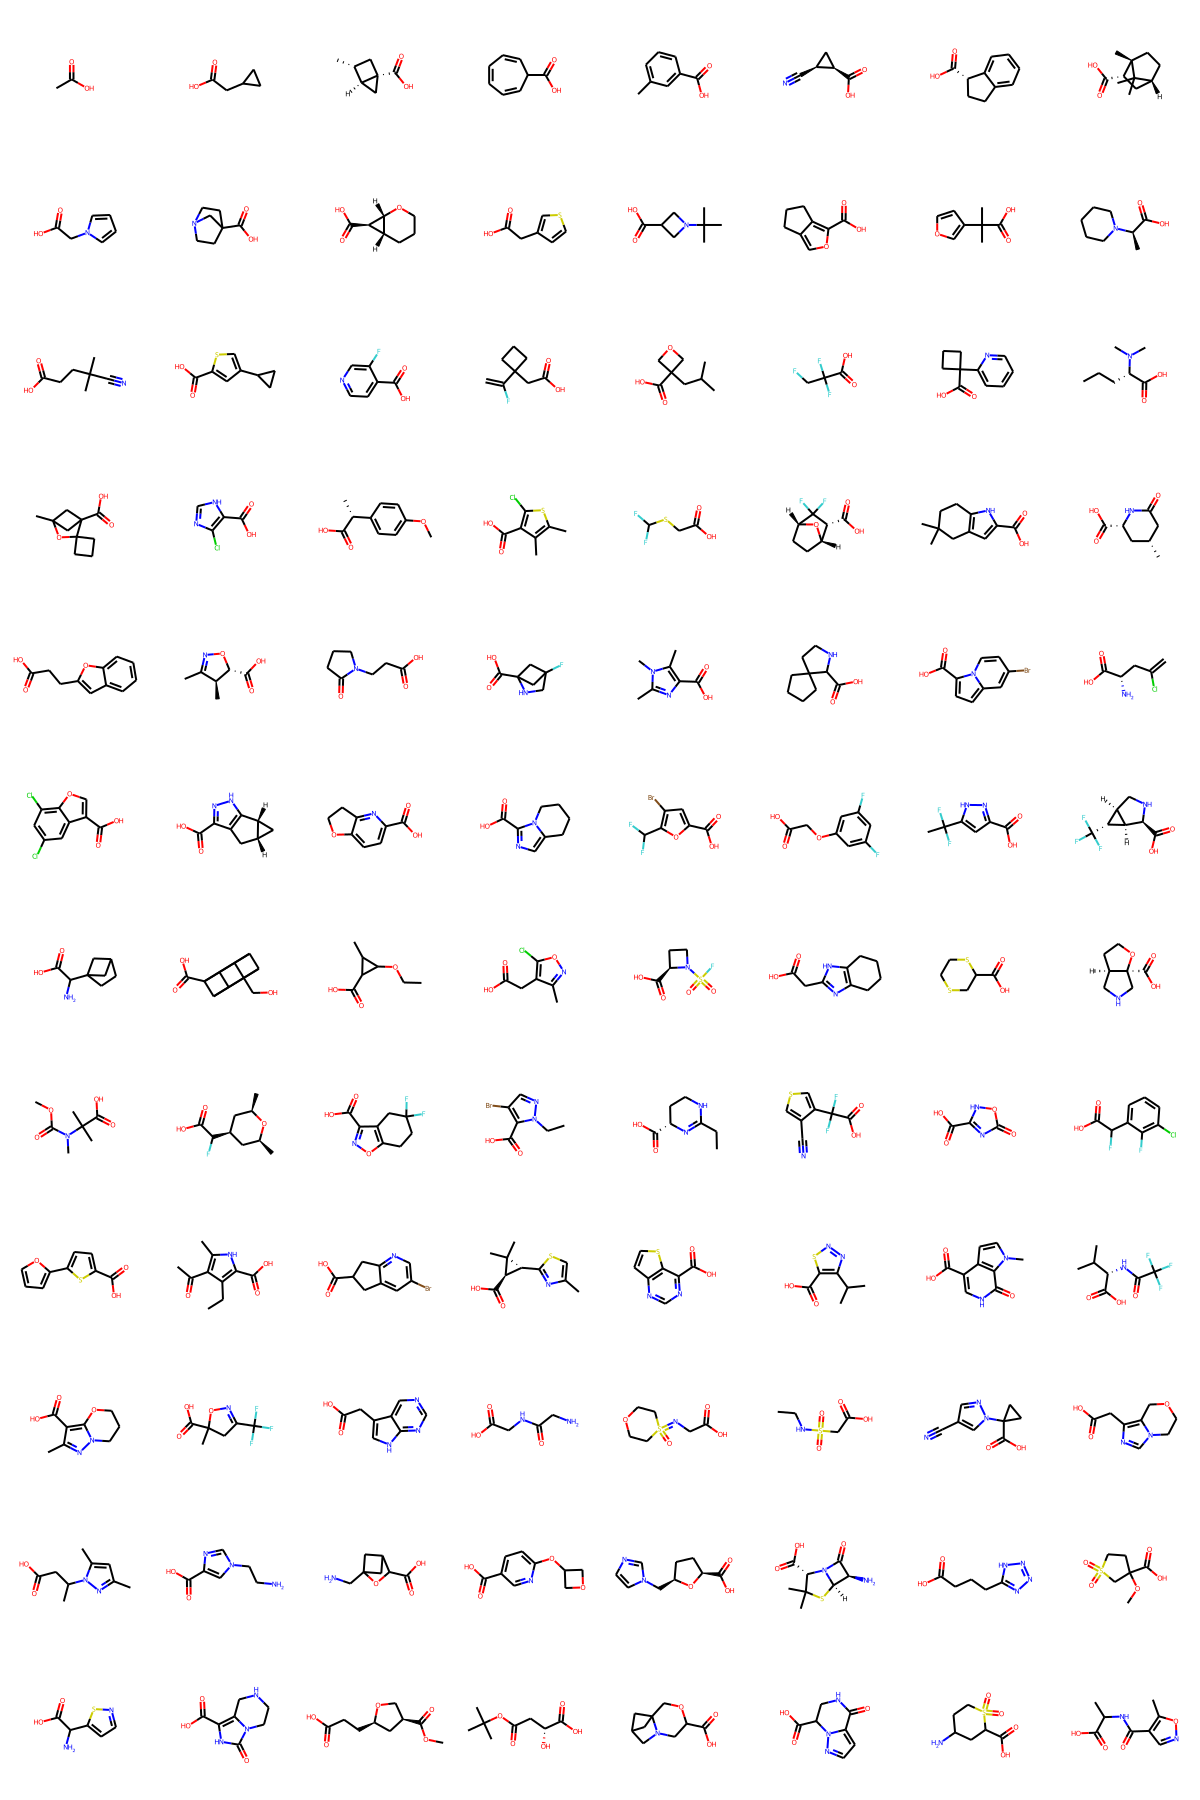

In [34]:
## Calculate fingerprints
## Equivalent to ECFP4 (diameter used in ECFP, radius used in Morgan)
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048) for m in mols]

## Start LeaderPicker object. This performs a fast sphere exclusion clustering without calculating similarity matrix
lp = rdSimDivPickers.LeaderPicker()

## Set similarity threshold for sphere exclusion clustering (minimum distance between cluster centroids)
thresh = 0.7668

## Get 'picks' which are essentially the cluster centroids, giving the indices in the list of molecules of the selected compounds
sphex_picks = lp.LazyBitVectorPick(fps,len(fps),thresh)
print(len(sphex_picks))
sphex_molnames = [molnames[x] for x in sphex_picks]
Draw.MolsToGridImage([mols[x] for x in sphex_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


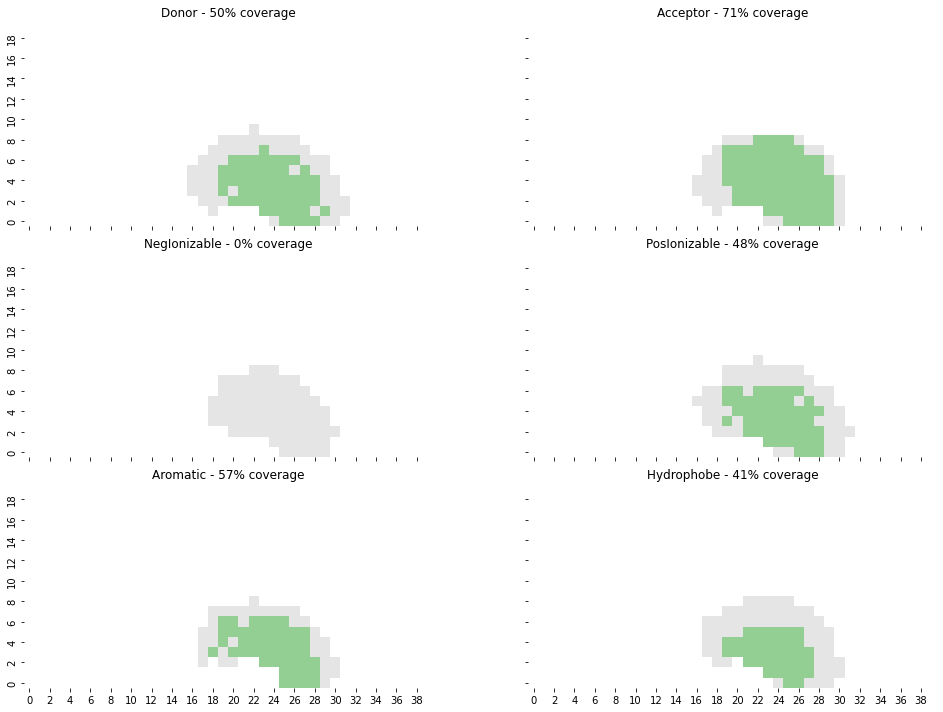

In [35]:
## Sphex coverage
classic_selection.SimulateCoverage(molnames = sphex_molnames)

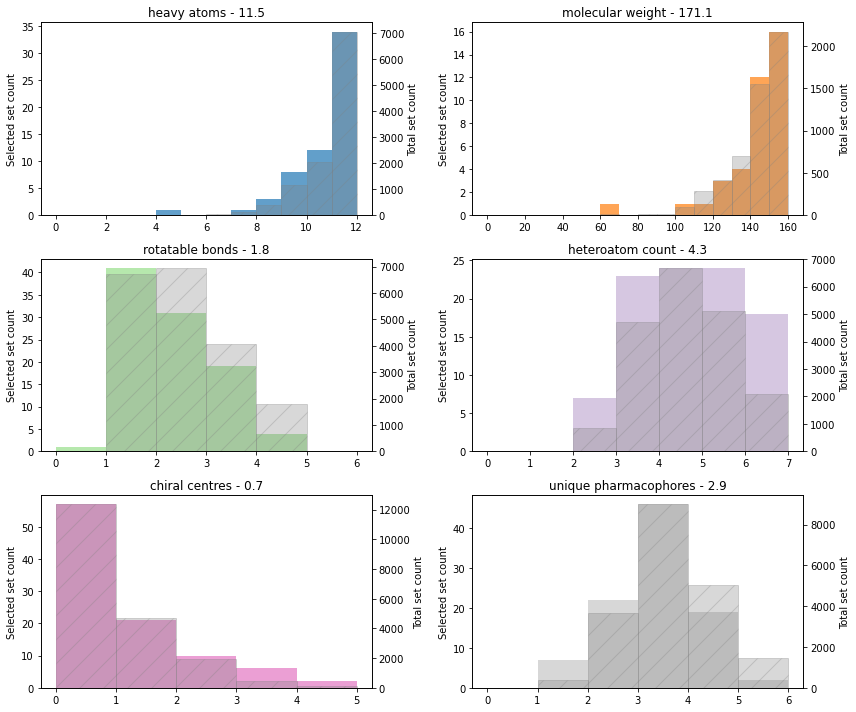

In [37]:
fig = visualise_properties(classic_selection.GetDataTable(), sphex_molnames, molnames, twinx = True)

## MaxMin picker
> - MaxMin picker algorithm taken from http://rdkit.blogspot.com/2013/10/fingerprint-thresholds.html and https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb
> - Picks things on edge of space. Is in paper Agrafiotis
> - refs:
>> - Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - http://rdkit.blogspot.com/2014/08/optimizing-diversity-picking-in-rdkit.html
>> - https://github.com/greglandrum/rdkit_blog/blob/master/notebooks/MaxMinPickerRevisited.ipynb

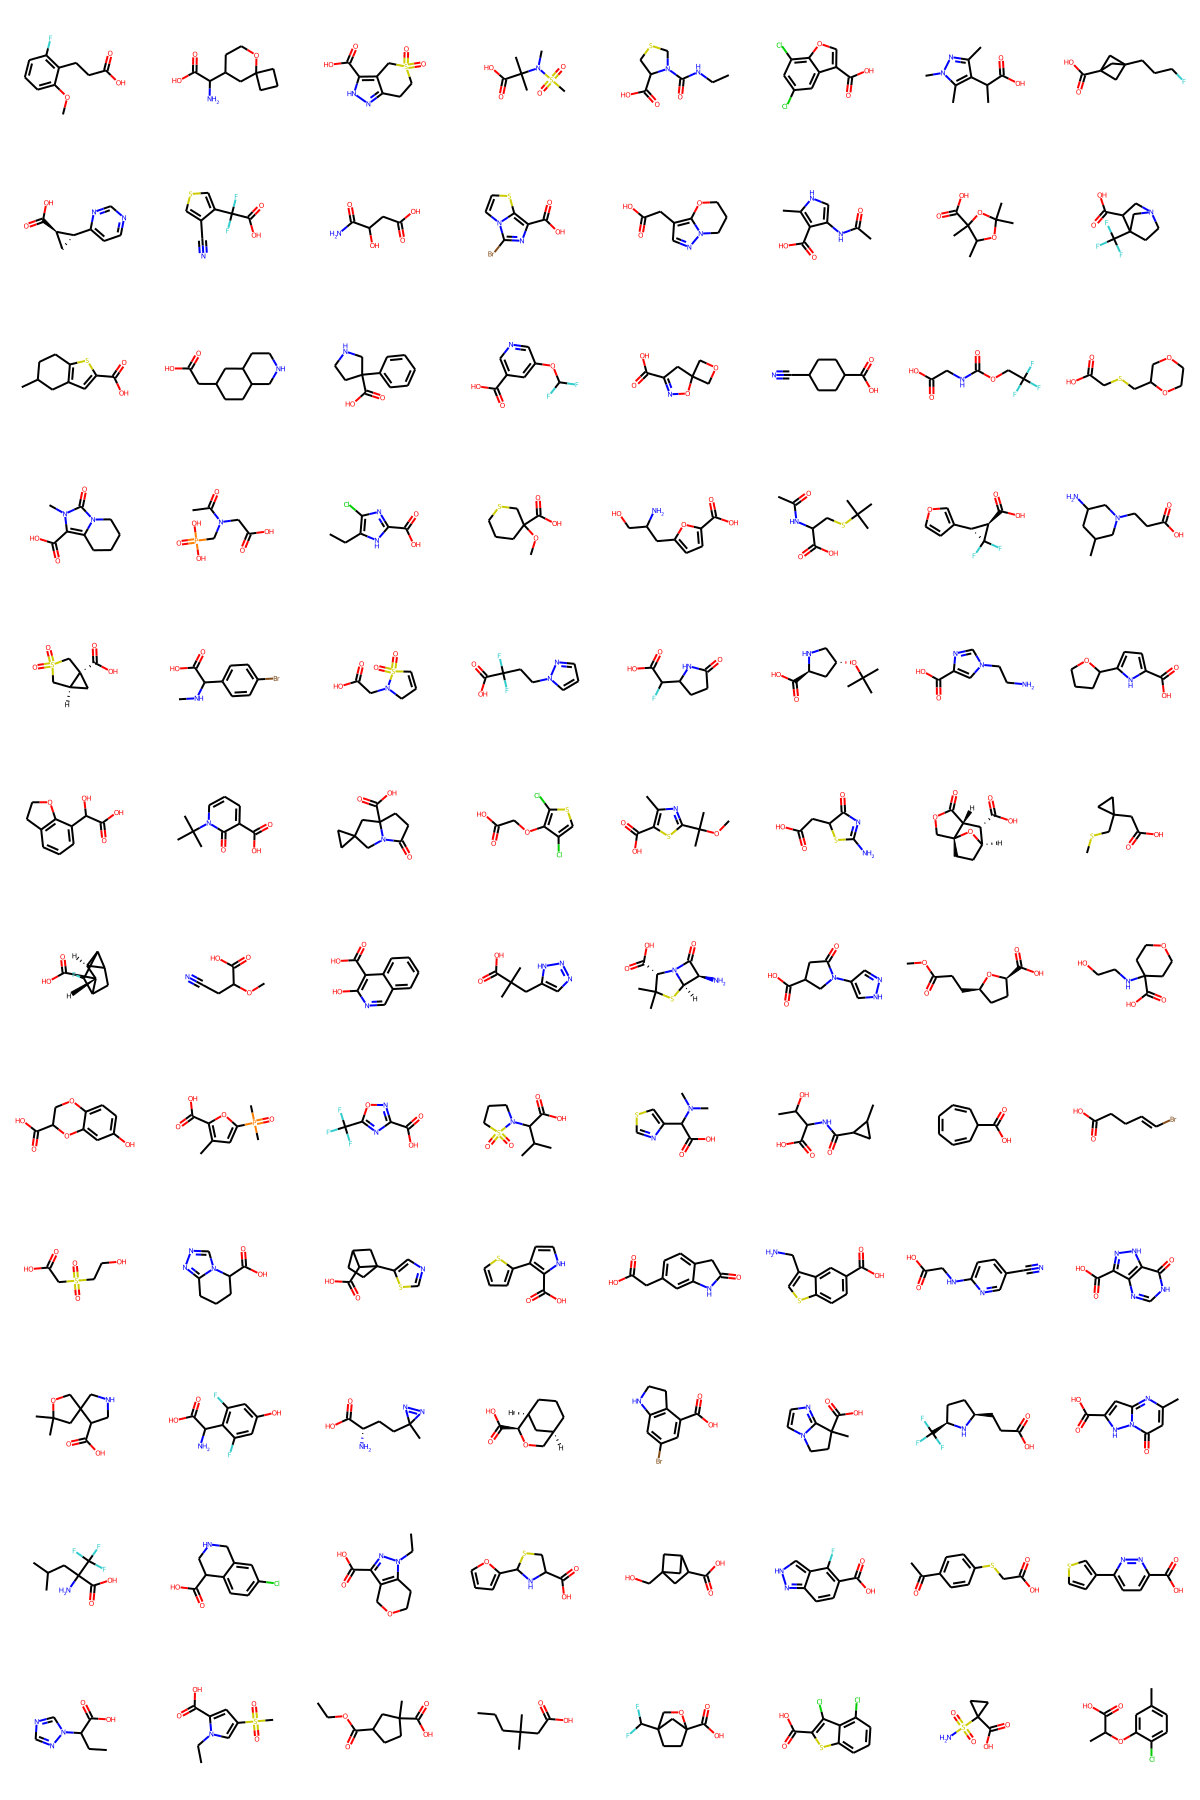

In [44]:
## Have to specify distance function. Here, you make it in a funcion
def fn(i,j,fps=fps):
    return 1.-DataStructs.TanimotoSimilarity(fps[i],fps[j])

## Start MaxMinPicker class
mmp =SimDivFilters.MaxMinPicker()

MaxMin_picks = mmp.LazyPick(fn,len(fps), n_select, seed=3)
MaxMin_molnames = [molnames[x] for x in MaxMin_picks]
Draw.MolsToGridImage([mols[x] for x in MaxMin_picks], molsPerRow=8, subImgSize=(150,150), maxMols=100)

/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/fr645797/.conda/envs/a_francesco_env_22/lib/python3.9/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


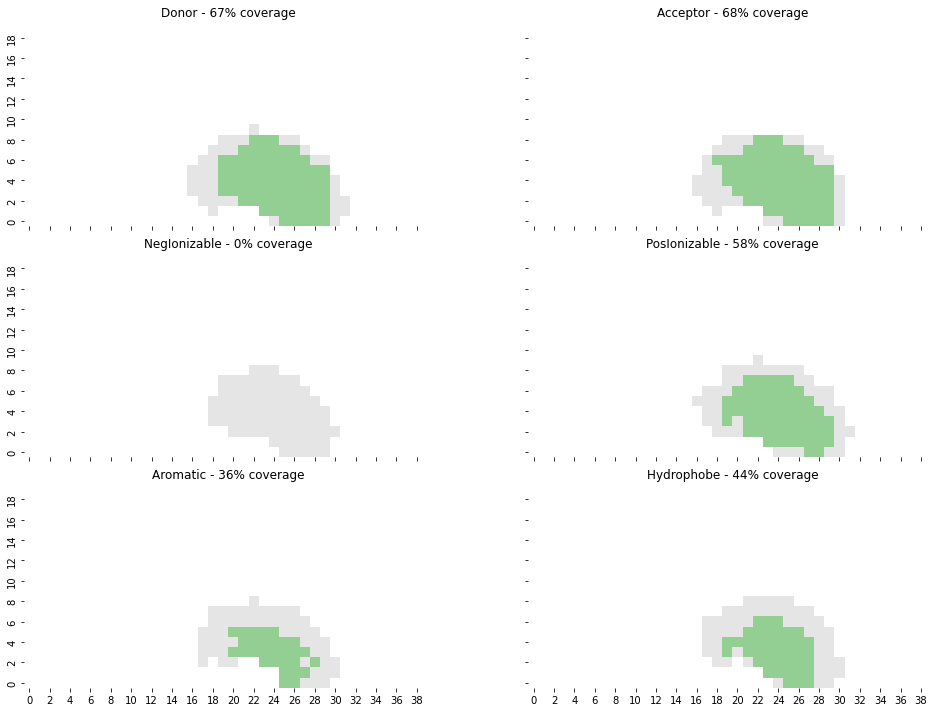

In [27]:
## MaxMin coverage
mGAPclustering.enumerate_coverage(molnames = MaxMin_molnames)
_ = mGAPclustering.visualise_pharmacophore_coverage(pharmacophore = '*')

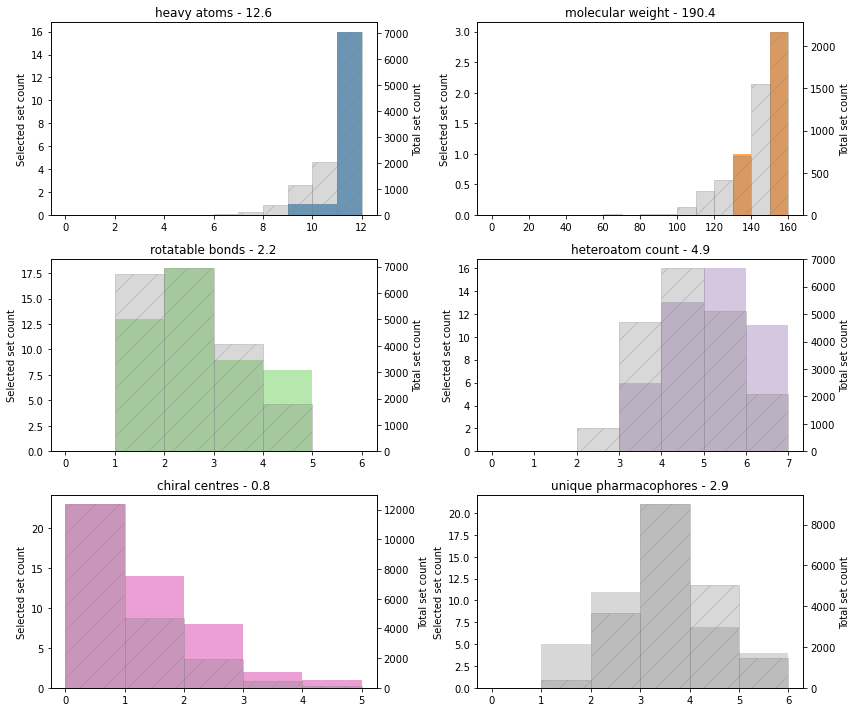

In [28]:
visualise_properties(mGAP_selection._selection_table, MaxMin_molnames, molnames, twinx = True)

# K-means clustering

> - Perform k-Means clustering on morgan2 fingerprints (equivalent to ECFP4)


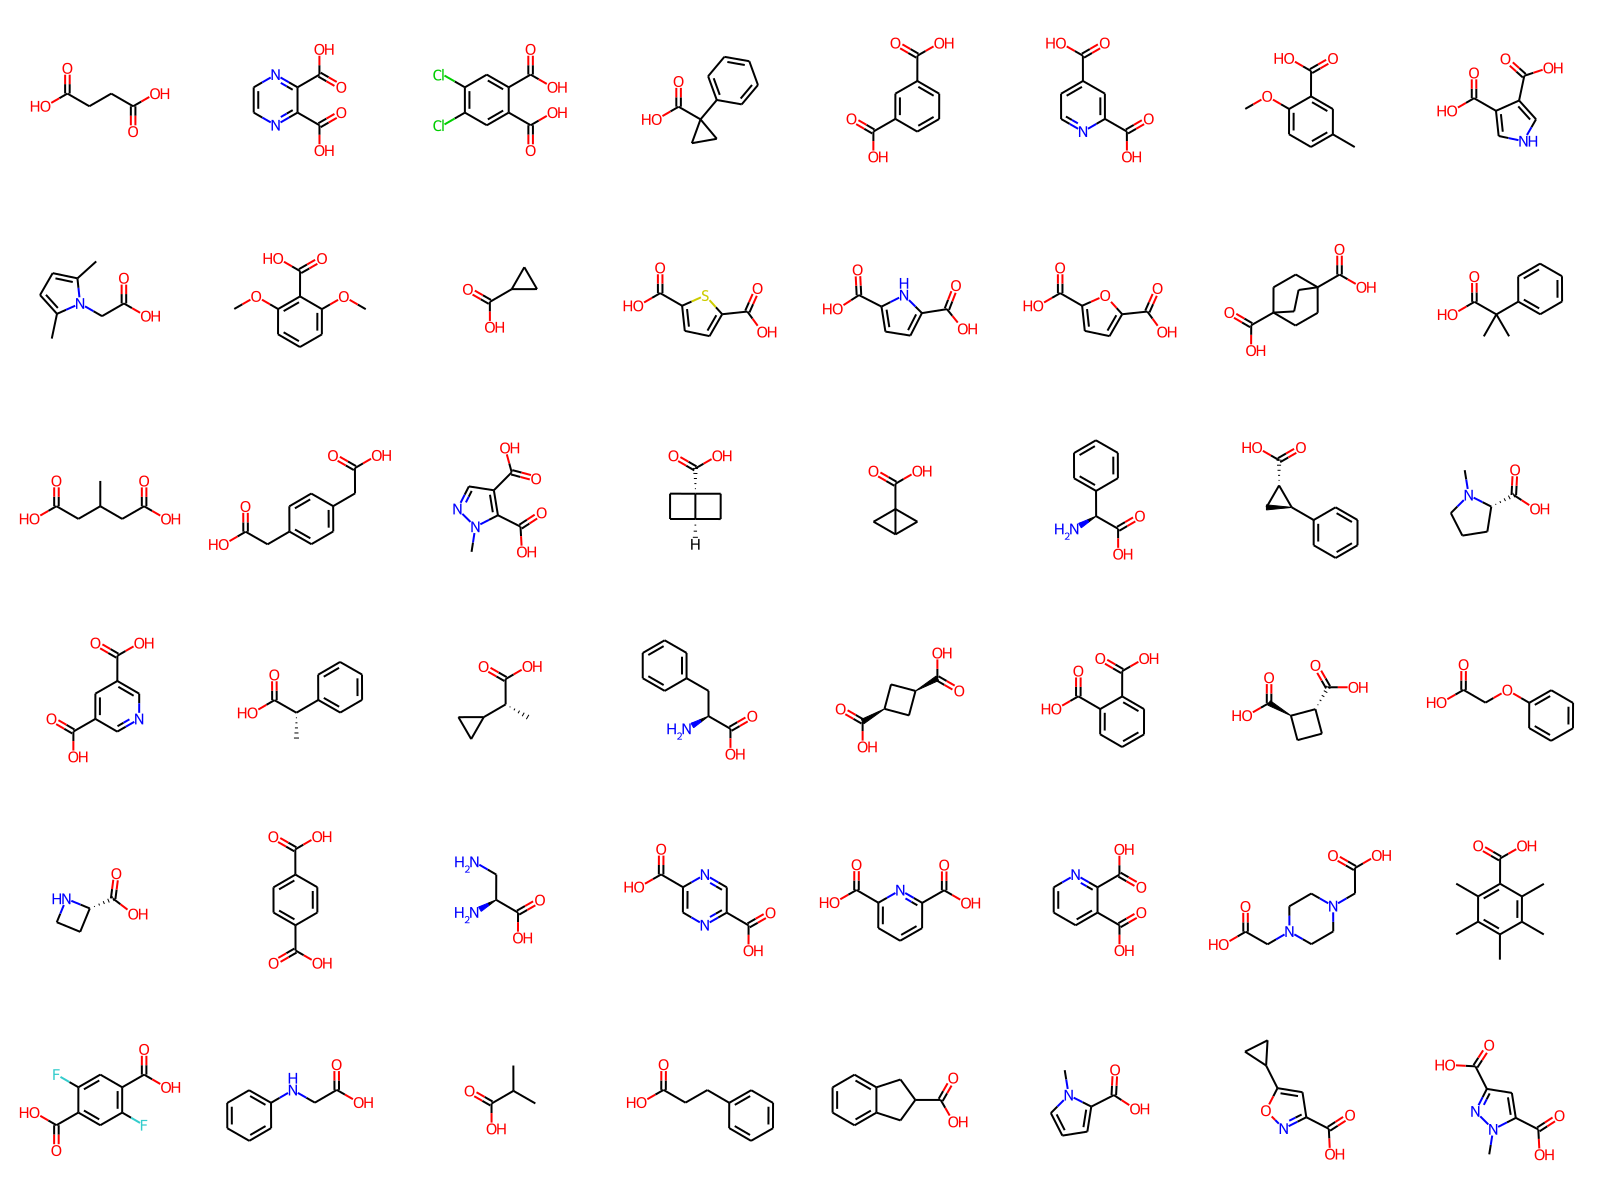

In [29]:
## Convert fingerprints into a list
fps_list = [list(fp) for fp in fps]

## Set the selection size e.g. number of k-means clusters
num_clusters = 48

## Initialise the k-means clustering object
km = KMeans(
    n_clusters=num_clusters, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=3)

## Perform k-means clustering
y_km = km.fit(fps_list)

## Number of iterations. If less that max_iter, convergence has been met
# y_km.n_iter_

## Get the clusters and the values of the centroids
m_clusters = y_km.labels_.tolist()
centers = np.array(y_km.cluster_centers_)

## Find the data point closest to the cluster centroid
k_means_molnames = []
k_means_picks = [] ## Indices of selection

## Iterate over the clusters

for i in range(num_clusters):
    ## Get the centroid vector
    center_vec = centers[i]
    
    ## Get the indices of the data points that are within each cluster
    data_idx_within_i_cluster = [ idx for idx, cluster_num in enumerate(m_clusters) if cluster_num == i ]
    
    ## Create a matrix where the number of rows = number of points in cluster and is the legnth of the data vector (length of fingerprint)
    ## This is a 'slice' of the data within the original data set which come from the cluster
    one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
    
    ## Iterate over the compounds within the cluster
    for row_num, data_idx in enumerate(data_idx_within_i_cluster):
        
        ## Get the fingerprint for the compound
        one_row = fps_list[data_idx]
        
        ## Set the fingerprint within the matrix
        one_cluster_tf_matrix[row_num] = one_row
    
    ## Calculate the closest compound to the centroid vector
    closest, distance = pairwise_distances_argmin_min(center_vec.reshape(1, -1), one_cluster_tf_matrix)
    
    ## Get the index of the closest compound to the centroid vector in the slice cluster list
    closest_idx_in_one_cluster_tf_matrix = closest[0]
    
    ## Get the index of the closest compound in the larger data set
    closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
    
    ## Get the molname
    data_id = molnames[closest_data_row_num]
    
    k_means_picks.append(closest_data_row_num)
    k_means_molnames.append(data_id)

k_means_molnames = list(set(k_means_molnames))
Draw.MolsToGridImage([ms[x] for x in k_means_picks],molsPerRow=8,maxMols=100)

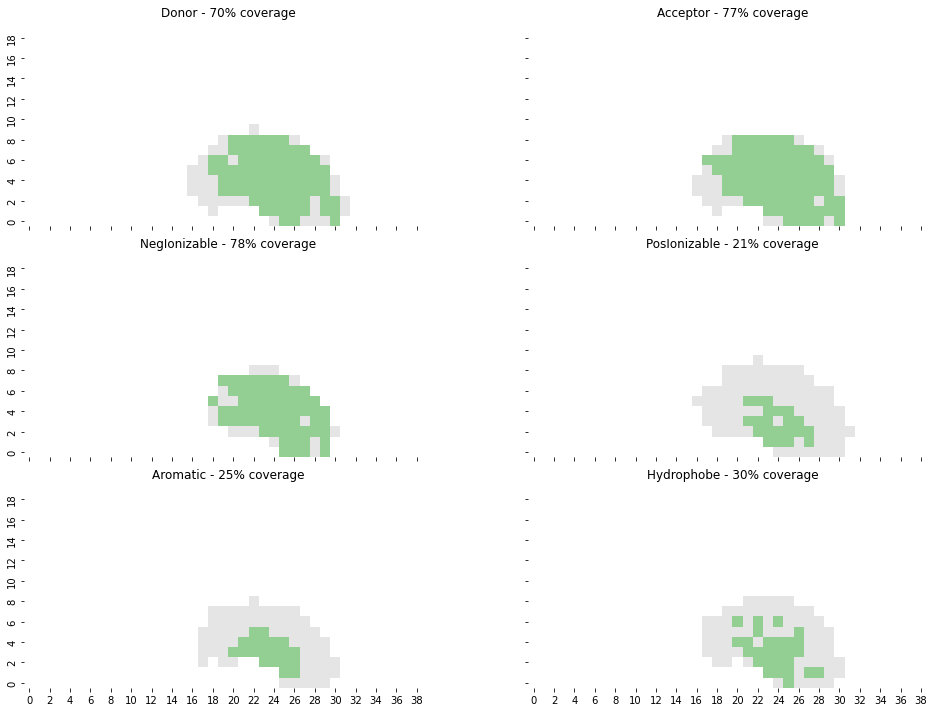

In [30]:
## k_means coverage
mGAPclustering.enumerate_coverage(molnames = k_means_molnames)
_ = mGAPclustering.visualise_pharmacophore_coverage(pharmacophore = '*')

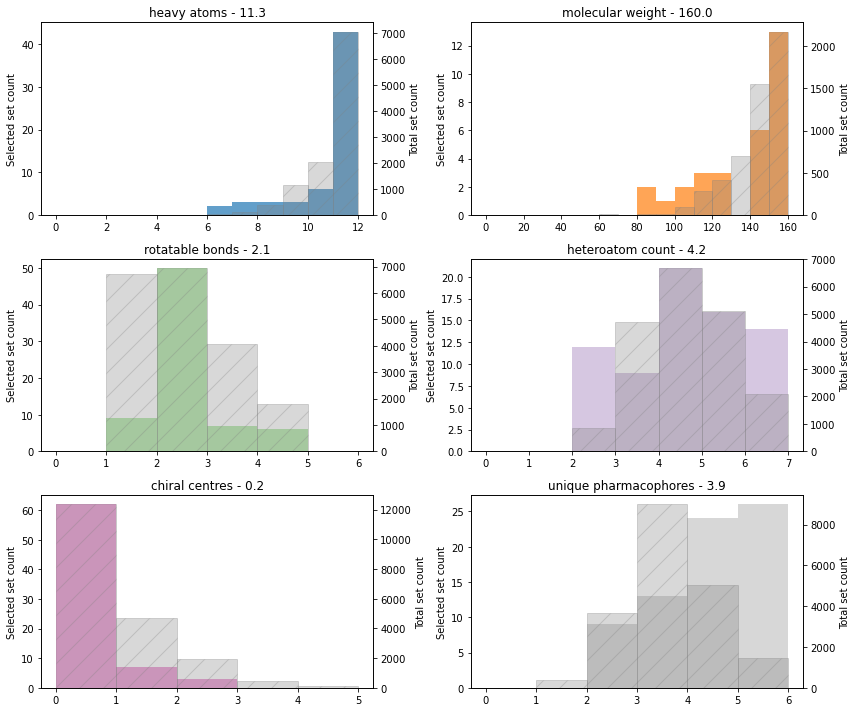

In [31]:
visualise_properties(mGAP_selection._selection_table, k_means_molnames, molnames, twinx = True)

## Tanimoto similarity histograms
- These histograms show a histogram of the Tanimoto similarities between all of the selected compounds

In [35]:
def similarity_histogram(pick_indices, fps, header = "", values = False, **kwargs):
    dist_hist=[]
    for i in range(len(pick_indices)):
        for j in range(i+1,len(pick_indices)):
            dist_hist.append(DataStructs.TanimotoSimilarity(fps[pick_indices[i]],fps[pick_indices[j]]))
    _=hist(dist_hist,bins=20,range=(0,1),**kwargs)
    _=title(header)
    _=xlabel("Similarity")
    if values:
        return dist_hist

In [36]:
# Histogram of overall similarity of set.. Takes long to calculate
#all_indices = [x for x, y in enumerate(fps)]

#full_set_similarity_values = similarity_histogram(all_indices, fps, header = 'Total set', values = True, linewidth = 1)
full_set_similarity_values = []
with open('./data/enamine_acids/enamine_acids/enamine_tanimoto_similarities.txt', 'r') as outfile:
    for line in outfile:
        full_set_similarity_values.append(float(strip(line)))

NameError: name 'strip' is not defined

In [ ]:
random_similarity_values = similarity_histogram(random_picks, fps, header = 'random', values = True)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(random_similarity_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.9))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('Random set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Random set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
plt.rcParams['figure.figsize'] = [12,8]
plt.hist(random_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
#plt.hist(mGAP_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.2))
plt.grid(which = 'both', markevery = 0.1)
plt.xticks([(x)/20 for x in range (21)])
plt.title('Random Morgan2 similarity')
plt.xlabel('Morgan2 similarity')
plt.ylabel('Count')

In [ ]:
#print(f'mean = {np.array(all_values).mean()}')
#print(f'median = {numpy.median(np.array(all_values))}')

In [ ]:
## List of selected IDS
plt.rcParams['figure.figsize'] = [15,10]
#mGap_IDs = ['V120525317','V120944988','V120943980','V120494911','V120944900','V120942083','V120510701','V120519225','V120943067','V120943874','V120465715','V120942960','V120944998','V120943404','V120944633','V120941002','V120495280','V120944902','V120496013','V120518607','V120941039','V120942779','V120943316','V120456020','V120943581','V120460720','V120470985','V120943995','V120532291','V120442362','V120943891','V120500911','V120943997','V120940935','V120516753','V120525387','V120941256','V120518413','V120943806','V120942660','V120943118','V120944955','V120944929','V120943066','V120940987','V120941111','V120942445','V120942667','V120943779','V120240905','V120944965','V120943325','V120944994','V120492622','V120942663','V120943160','V120943550','V120240891','V120943070','V120941753','V120942704','V120942697','V120941041','V120492890']
mGap_IDs = selected_molnames
## Get the indices in the list of the selected compounds
mGAP_picks = [list(molnames).index(i) for i in mGap_IDs]
mGAP_sim_values = similarity_histogram(mGAP_picks, fps, header = 'mGAP', values = True)

In [ ]:
plt.rcParams['figure.figsize'] = [12,8]
plt.hist(random_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
plt.hist(mGAP_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.2))
plt.grid(which = 'both', markevery = 0.1)
plt.xticks([(x)/20 for x in range (21)])
plt.title('mGAP Morgan2 similarity')
plt.xlabel('Morgan2 similarity')
plt.ylabel('Count')

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(mGAP_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.2))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('mGAP set-based selection set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('mGAP set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
maxmin_similarity_values = similarity_histogram(MaxMin_picks, fps, header = 'MaxMin', values = True)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(maxmin_similarity_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.3))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('MaxMin set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('MaxMin set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
sphex_sim_values = similarity_histogram(sphex_picks, fps, header = 'Sphere Exclusion', values = True)

In [ ]:
kmeans_sim_values = similarity_histogram(k_means_picks, fps, header = 'k-means', values = True)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(kmeans_sim_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.4))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('k-means set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('k-means set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
sphex_similarity_values = similarity_histogram(sphex_picks, fps, header = 'random', values = True)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(sphex_similarity_values,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.8))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('Sphere exclusion set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('Sphere exclusion set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
sim_values = [full_set_similarity_values, mGAP_sim_values, random_similarity_values, maxmin_similarity_values, sphex_sim_values, kmeans_sim_values]

In [ ]:
for sim_value in sim_values:
    hist(sim_value,bins=20,range=(0,1))

# What is the overlap between the selections?
- This shows the number of compounds in common each of the selection methods have with mGAP

In [ ]:
# mGAP and Sphex
len(set(selected_molnames) & set(sphex_molnames))

In [ ]:
# mGAP and MaxMin
len(set(selected_molnames) & set(MaxMin_molnames))

In [ ]:
# mGAP and k_means
len(set(selected_molnames) & set(k_means_molnames))

In [ ]:
# Sphex and MaxMin
len(set(sphex_molnames) & set(MaxMin_molnames))

In [ ]:
## mGAP and random
set(selected_molnames) & set(random_molnames)

In [ ]:
selected_molnames2[-1]

In [ ]:
selected_mols2 = []
for smiles in selected_smiles2.keys():
    selected_mol = Chem.MolFromSmiles(smiles)
    AllChem.GenerateDepictionMatching2DStructure(selected_mol , align_mol)
    #selected_mol.SetProp('_Name',f"{selected_smiles[smiles]['pharmacophore']}\n{selected_smiles[smiles]['molname'].split(':')[0]}")
    selected_mol.SetProp('_Name',f"{selected_smiles2[smiles]['pharmacophore']}")
    selected_mols2.append(selected_mol)

Draw.MolsToGridImage(selected_mols2, molsPerRow=8,legends = [x.GetProp("_Name") for x in selected_mols],subImgSize=(150,150), maxMols = 96)

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))

#ax1.rcParams['figure.figsize'] = [12,8]
#ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax2 = ax1.twinx()
ax2.hist(mGAP_sim_values2,bins=20,range=(0,1), alpha = 0.7, color = plt.get_cmap('tab20')(0.25))
ax1.grid(which = 'both', markevery = 0.1)
ax1.set_xticks([(x)/20 for x in range (21)])
ax2.set_title('mGAP space-based selection set Morgan2 similarity vs Total set')
ax2.set_xlabel('Morgan2 similarity')
ax2.set_ylabel('mGAP set count')


ax1.hist(full_set_similarity_values,bins=20,range=(0,1), color = 'grey', alpha = 0.4, hatch = '/', edgecolor = 'grey')
ax1.set_ylabel('Total set count')

In [ ]:
len(set(selected_molnames) & set(selected_molnames2))

In [ ]:
mGAPclustering2.pharmacophore('10_H').visualise_even_clusters(False)